In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import bayes_mvs as bayesest
import os #Lib for get the operative system sintaxis
from sklearn import linear_model#Machine learning package for a smart plot fit
from scipy import stats
from decimal import Decimal
import math
import seaborn as sns
from tqdm import tqdm

In [2]:
def indexes(y):#peak detection algorithm
    dy = np.diff(y)
    #plt.plot(ady)
    ind = []
    for i in range(len(dy)-1):
        if len(ind) > 0:
            if abs(dy[i-1])<0.25*y[i] and dy[i]<-0.3*y[i] and abs(dy[i+1])<0.25*y[i]:
                ind.append(i)
        elif len(ind) == 0:
            if  dy[i]<-0.3*y[i]:
                ind.append(i)
    return ind  

In [6]:
pixelsize=0.11 #pixelsize (mum/px)
timebetframes=15/60
fitthresh=0.8

In [8]:
%matplotlib inline
data=pd.read_csv("./RawDataAdder.csv")
replica=[1,3]#data['Replica'].unique()

    
plt.rcParams.update({'figure.max_open_warning': 0})
#data=dataraw[dataraw.lane_num==lane]

DSMdata=[]#np.array([["Sb","Sd","gr","timediv","score","Replica"]])
CRMdata=[]#np.array([["Mother","time","SizeFit","Size","gr","score","Replica"]])
CRMdatasyn=[]
#td=[]
#goodsz=[]
#grsimple=[]
#gooddata=[]
filtdata=[]
repinx=1
for rep in replica:
    df=data[data.Replica==rep]
    moms=df['mom'].unique()
    grs=[]
    df=df.reset_index()
    tbf=(df.loc[1].time-df.loc[0].time)*15/60
    for k in range(len(moms)):
        tempCRM=[]
        tempCRMsyn=[]
        tempv=[]
        dataM=df[df.mom==moms[k]]
        datat=dataM.sort_values(by="time")
        ln = np.array(datat.length)
        
        time = np.array(datat.time*15/60)
        
        peaksval=[]  
        fitl=[]
        fitt=[]
        peaks = indexes(ln)
        avscore=[]
        if (len(peaks)!=0):
            coor=[]
            for i in range(len(peaks)):        
                if(i>0):
                    d=float(time[peaks[i]]-time[peaks[i-1]])#division time
                    tt=peaks[i-1]+1#initial time for ransac estimation
                    tt2=peaks[i-1]-peaks[0]+1
                else:
                    d=0
                    tt=0
                peaksval.append([time[peaks[i]],ln[peaks[i]]]) 
                dt=[]#array of log(len)
                tm=[]
                results=[]
                temp=0
                while(tt<=peaks[i]):
                    dt.append(np.log(ln[tt]))
                    tm.append(temp)
                    temp=temp+tbf
                    tt=tt+1
                if(len(dt)>1):#guarantees there is enought data
                    tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                    model_ransac.fit(tm,dt)#smart fit
                    a=model_ransac.estimator_.coef_#growth rate
                    l0=np.exp(model_ransac.estimator_.intercept_)
                    avscore.append(model_ransac.score(tm, dt))
                    if(i>0):
                        tt=peaks[i-1]+1#temporaltime
                        tt2=peaks[i-1]-peaks[0]+1
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tempCRMsyn.append([moms[k],time[tt2],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt+=1
                            tt2+=1
                        if(score>0.9):                        
                            tempvf=l0*np.exp((-time[peaks[i-1]+1]+time[peaks[i]]+(tbf/2))*a[0])
                            tempv0=l0*np.exp(-tbf*a[0]/2)
                            if tempvf>tempv0:                            
                                avt=(time[peaks[i-1]]+time[peaks[i]])/2
                                timediv=-time[peaks[i-1]]+time[peaks[i]]
                                tempv.append([tempv0,tempvf,tempvf-tempv0,a[0],avt,timediv,score,repinx])
                                tt=peaks[i-1]+1#temporaltime
                                if(model_ransac.score(tm,dt)>fitthresh):
                                    coor.append([time[peaks[i]],pixelsize*ln[peaks[i]],model_ransac.score(tm,dt)])
                        tt=peaks[i-1]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                            
                                
                    else:
                        tt=0
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[0]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1
                if i==len(peaks)-1:

                    tt=peaks[i]+1#initial time for ransac estimation
                    dt=[]#array of log(len)
                    tm=[]
                    results=[]
                    temp=0
                    while(tt<len(ln)):
                        dt.append(np.log(ln[tt]))
                        tm.append(temp)
                        temp=temp+tbf
                        tt=tt+1
                    if(len(dt)>1):#guarantees there is enought data
                        tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                        model_ransac.fit(tm,dt)#smart fit
                        a=model_ransac.estimator_.coef_#growth rate
                        l0=np.exp(model_ransac.estimator_.intercept_)
                        avscore.append(model_ransac.score(tm, dt))
                        tt=peaks[i]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                        while(tt<len(ln)):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1
            peaksval=np.array(peaksval)
        if len(tempv)>4:
            fitl=[]
            fitt=[]
            for gg in tempCRM:     
                if len(CRMdata)==0:
                    CRMdata=[gg]
                else:
                    CRMdata=np.concatenate((CRMdata,[gg]),axis=0)
                
                fitl.append(gg[2])
                fitt.append(gg[1])
            for gg in tempCRMsyn:     
                if len(CRMdatasyn)==0:
                    CRMdatasyn=[gg]
                else:
                    CRMdatasyn=np.concatenate((CRMdatasyn,[gg]),axis=0)
            for pp in tempv:
                if len(DSMdata)==0:
                    DSMdata=[pp]
                else:
                    DSMdata=np.concatenate((DSMdata,[pp]),axis=0)
    print(repinx)
    repinx+=1

1


In [ ]:

df=pd.DataFrame(DSMdata,columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
dataf=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
Rep=df.Replica.unique()
for r in Rep:
    df2=df[df.Replica==r]
    sz=np.mean(df2.Sb)
    dftemp=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
    dftemp['Sb']=df2.Sb/sz
    dftemp['Sd']=df2.Sd/sz
    dftemp['Added']=df2.Sb/sz
    dftemp['gr']=df2.gr
    dftemp['timediv']=df2.timediv
    dftemp['timecycle']=df2.timecycle*np.mean(df2.gr)/np.log(2)
    dftemp['score']=df2.score
    dftemp['Replica']=df2.Replica
    dataf=pd.concat([dataf,dftemp])
    
df=dataf
df=df[np.abs(scipy.stats.zscore(df.Sd))<3]
df=df[np.abs(scipy.stats.zscore(df.Sb))<3]
df=df[np.abs(scipy.stats.zscore(df.Added))<3]
df=df[np.abs(scipy.stats.zscore(df.gr))<3]
df=df[np.abs(scipy.stats.zscore(df.timecycle))<3.5]
df=df[df.score>0.8]


df.to_csv("./DSMdataAdder.csv",index=False)

#df.to_csv("./DSMdataAdder.csv",index=False)
df=pd.DataFrame(CRMdata,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[18,19.4]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=[1,3]
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataAdder.csv",index=False)
df=pd.DataFrame(CRMdatasyn,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[18,19.4]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=[1,3]
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataAddersyn.csv",index=False)

In [ ]:
#cell cycles before synchonization

data=pd.read_csv("./CRMdataAdder.csv")

for r in [1,3]:
    
    df=data[data.Replica==r]
    for i in range (10):
        mom=df.Mother.unique()[i]
        dfmom=df[df.Mother==mom]
        plt.plot(dfmom.time,dfmom.SizeFit,lw=0.5,c='#bebebe')
    tarray=np.sort(df.time.unique())
    meansz=[]
    errorsz=[]
    meancv2sz=[]
    errorcv2sz=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz.append(mean_cntr[0])
            errorsz.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz.append(errv)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray,meansz,lw=3)
    plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)

plt.ylim([0,4])

<ipython-input-9-febc68b278dc>:22: RuntimeWarning: invalid value encountered in double_scalars
  meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
<ipython-input-9-febc68b278dc>:23: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
<ipython-input-9-febc68b278dc>:28: RuntimeWarning: invalid value encountered in add
  plt.fill_between(tt, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
<ipython-input-9-febc68b278dc>:23: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3


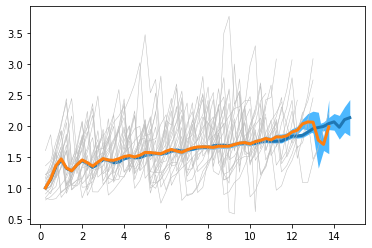

In [9]:
#Cellcycles after syncronization
data=pd.read_csv("./CRMdataAddersyn.csv")
i=0
for r in [1,3]:
    df=data[data.Replica==r]
    for i in range (10):
        mom=df.Mother.unique()[i]
        dfmom=df[df.Mother==mom]
        plt.plot(dfmom.time,dfmom.Size,lw=0.5,c='#bebebe')
    tarray=np.sort(df.time.unique())
    meansz=[]
    errorsz=[]
    meancv2sz=[]
    errorcv2sz=[]
    tt=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(dft)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz.append(mean_cntr[0])
            errorsz.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz.append(errv)
            tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tt,meansz,lw=3)
    plt.fill_between(tt, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1


(0.05, 0.14)

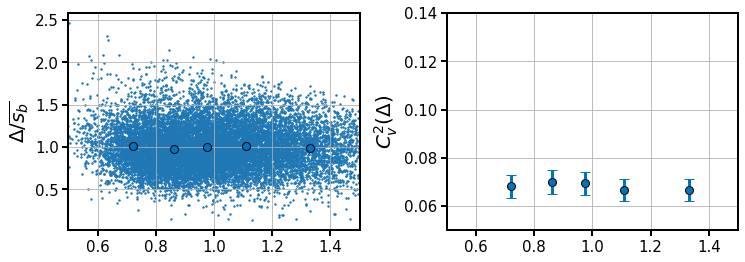

In [10]:
#Division Strategy: Adder
fig, ax = plt.subplots(1,2, figsize=(12,4))
data2=pd.read_csv("./DSMdataAdder.csv")
data2=data2[data2.score>0.9]
ax[0].scatter(data2.Sb/np.mean(data2.Sb),(data2.Sd-data2.Sb)/np.mean(data2.Sb),s=2)

quantnumber=5
pvadd2=data2
CV2d=[]
delt=[]
sb=[]
    
errcv2d=[]
errdelt=[]
errsb=[]
for i in range(quantnumber):
    lperv0=np.percentile(pvadd2.Sb,i*100/quantnumber)
    hperv0=np.percentile(pvadd2.Sb,(i+1)*100/quantnumber)
    quanta1=pvadd2[pvadd2.Sb>lperv0]
    quanta2=quanta1[quanta1.Sb<hperv0]     
    mean_cntr, var_cntr, std_cntr = bayesest((quanta2.Sd-quanta2.Sb)/np.mean(pvadd2.Sd-pvadd2.Sb),alpha=0.95)
    meanv0_cntr, varv0_cntr, stdv0_cntr = bayesest(quanta2.Sb/np.mean(pvadd2.Sb),alpha=0.95)
    CV2d.append(var_cntr[0]/mean_cntr[0]**2)
    delt.append(mean_cntr[0])
    sb.append(meanv0_cntr[0])
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2d.append(errv)
    errdelt.append(mean_cntr[1][1]-mean_cntr[0])
    errsb.append(meanv0_cntr[1][1]-meanv0_cntr[0])
ax[0].errorbar(np.array(sb),np.array(delt),xerr=errsb,yerr=errdelt, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].errorbar(np.array(sb),CV2d,xerr=errsb,yerr=errcv2d, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].set_ylim([0,0.3])


ax[0].set_xlim(0.5,1.5)
ax[1].set_xlim(0.5,1.5)
for i in [0,1]:
    ax[i].grid()
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].tick_params(axis='both', width=2,length=6)
        #ax[i].legend(fontsize=15)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel(r'$\Delta/\overline{s_b}$',size=20)
ax[1].set_ylabel(r'$C^2_v(\Delta)$',size=20)
ax[1].set_ylim(0.05,0.14)

Text(0.5, 0, 'Time (h)')

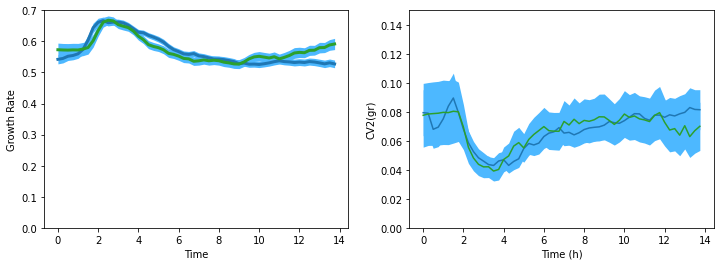

In [11]:
#Growth Rate along the time
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,4))
data=pd.read_csv("./CRMdataAdder.csv")
data=data[data.score>0.95]
data=data[data.time<14]
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    tarray=np.sort(df.time.unique())
    meangr=[]
    errorgr=[]
    meancv2gr=[]
    errorcv2gr=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
            grarr=np.array(dft.gr.tolist())
            grarr=grarr[np.abs(grarr-np.mean(grarr))<3*np.std(grarr)]
            mean_cntr, var_cntr, std_cntr = bayesest(grarr,alpha=0.95)
            meangr.append(mean_cntr[0])
            errorgr.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2gr.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2gr.append(errv)
    ax[0].plot(tarray,meangr,lw=3)
    ax[0].fill_between(tarray, np.array(meangr)+np.array(errorgr), np.array(meangr)-np.array(errorgr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    ax[1].plot(tarray,meancv2gr)
    ax[1].fill_between(tarray, np.array(meancv2gr)+np.array(errorcv2gr), np.array(meancv2gr)-np.array(errorcv2gr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    
ax[0].set_ylim([0,0.7])
ax[1].set_ylim(0,0.15)
ax[0].set_ylabel('Growth Rate')
ax[0].set_xlabel('Time')

ax[1].set_ylabel('CV2(gr)')
ax[1].set_xlabel('Time (h)')

0.01460863445988946
0.010577899308616894


(0.0, 1.0)

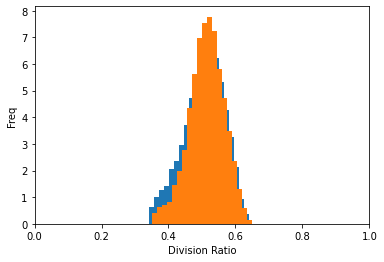

In [12]:
#Noise in partitioning

data=pd.read_csv("./CRMdataAdder.csv")

for rep in data.Replica.unique():
    dfrep=data[data.Replica==rep]
    ratioarr=[]
    for mom in dfrep.Mother.unique():
        dfmom=dfrep[dfrep.Mother==mom]
        ln=np.array(dfmom.SizeFit.tolist())
        grarr=np.array(dfmom.gr.tolist())
        peaks = indexes(ln)

        for i in range(len(peaks)):
            rat=(ln[peaks[i]+1]/ln[peaks[i]])*np.exp(-0.5*0.25*(grarr[peaks[i]]+grarr[peaks[i]+1]))
            ratioarr.append(rat)
    ratioarr=np.array(ratioarr)
    ratioarr=ratioarr[np.abs(ratioarr-np.mean(ratioarr))<0.15]
    print(np.var(ratioarr)/np.mean(ratioarr)**2)
    plt.hist(ratioarr,bins=20,density=True);
plt.xlabel('Division Ratio')
plt.ylabel('Freq')
plt.xlim(0,1)

In [13]:
def bootcorr(x,y):
    slopearr=[]
    for i in range(100):
        xboot=[]
        yboot=[]
        for m in range(len(x)):
            i=np.random.randint(0,len(x))
            xboot.append(x[i])
            yboot.append(y[i])
        corr=np.corrcoef(xboot,yboot)[0,1]
        slopearr.append(corr)
    mn=np.mean(slopearr)
    up=np.quantile(slopearr,0.95)
    down=np.quantile(slopearr,0.05)
    return(mn,0.5*(-down+up))  

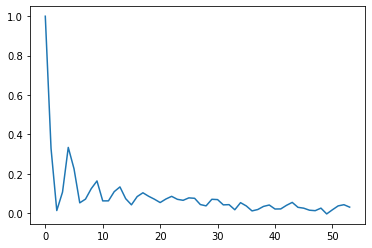

In [16]:
data=pd.read_csv("./CRMdataAdder.csv")
data=data[data.time>2]
data=data[data.Replica!=2.0]
tarr=data.time.unique()
timebet=tarr[1]-tarr[0]
tauarr=tarr[:25]
datacorr=[]
mnarr=[]

mnarr=[]
stdarr=[]
for t in tarr:
    dft=data[data.time==t]
    mnarr.append(np.mean(dft.Size))
    stdarr.append(np.std(dft.Size))
for j in range(len(tarr)):
    data1=[]
    data2=[]
    for rep in data.Replica.unique():
        dfrep=data[data.Replica==rep]
        for mom in dfrep.Mother.unique():
            dfmom=dfrep[dfrep.Mother==mom]
            sizes=dfmom.Size.tolist()
            if len(sizes)>j:
                data1.append((sizes[0]-mnarr[0])/stdarr[0])
                data2.append((sizes[j]-mnarr[j])/stdarr[j])
    if len (data1)>1 and len(data2)>1:
        corr,err=bootcorr(data1,data2)
        datacorr.append([j*timebet,corr,err])
singledf=pd.DataFrame(datacorr,columns=['Time','Corr','ErrCorr'])

singledf.to_csv('./CorrelationAdder.csv',index=False)
plt.plot(singledf.Corr)

<ipython-input-19-ba78bdf39e1d>:19: RuntimeWarning: invalid value encountered in double_scalars
  meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
<ipython-input-19-ba78bdf39e1d>:20: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
C:\Users\cesar_nieto\anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cesar_nieto\anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


(0.9, 1.7)

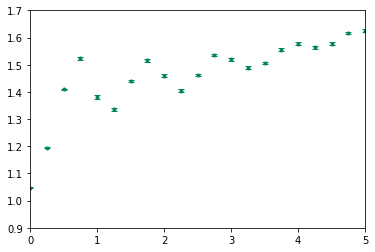

In [19]:
data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    #print(len(dft))
    if (len(dft)>1):
        szs=np.array(dft.Size.tolist())
        szs=szs[np.abs(szs-np.mean(szs))<3.*np.mean(szs)]
        #print(len(dft))
        mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
plt.errorbar((np.array(tt)-0.25),1.05*(np.array(meansz)),yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.xlim(0,5)
plt.ylim(0.9,1.7)

In [ ]:
%matplotlib inline
data=pd.read_csv("./RawDataSizer.csv")
replica=data['Replica'].unique()

    
plt.rcParams.update({'figure.max_open_warning': 0})

DSMdata=[]#np.array([["Sb","Sd","gr","timediv","score","Replica"]])
CRMdata=[]#np.array([["Mother","time","SizeFit","Size","gr","score","Replica"]])
CRMdatasyn=[]

filtdata=[]
repinx=1
for rep in replica:
    df=data[data.Replica==rep]
    moms=df['mom'].unique()
    grs=[]
    df=df.reset_index()
    tbf=(df.loc[1].time-df.loc[0].time)/60
    for k in range(len(moms)):
        tempCRM=[]
        tempCRMsyn=[]
        tempv=[]
        dataM=df[df.mom==moms[k]]
        datat=dataM.sort_values(by="time")
        ln = np.array(datat.length)
        
        time = np.array(datat.time/60)
        
        peaksval=[]  
        fitl=[]
        fitt=[]
        peaks = indexes(ln)
        avscore=[]
        if (len(peaks)!=0):
            coor=[]
            for i in range(len(peaks)):        
                if(i>0):
                    d=float(time[peaks[i]]-time[peaks[i-1]])#division time
                    tt=peaks[i-1]+1#initial time for ransac estimation
                    tt2=peaks[i-1]-peaks[0]+1
                else:
                    d=0
                    tt=0
                peaksval.append([time[peaks[i]],ln[peaks[i]]]) 
                dt=[]#array of log(len)
                tm=[]
                results=[]
                temp=0
                while(tt<=peaks[i]):
                    dt.append(np.log(ln[tt]))
                    tm.append(temp)
                    temp=temp+tbf
                    tt=tt+1
                if(len(dt)>1):#guarantees there is enought data
                    tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                    model_ransac.fit(tm,dt)#smart fit
                    a=model_ransac.estimator_.coef_#growth rate
                    l0=np.exp(model_ransac.estimator_.intercept_)
                    avscore.append(model_ransac.score(tm, dt))
                    if(i>0):
                        tt=peaks[i-1]+1#temporaltime
                        tt2=peaks[i-1]-peaks[0]+1
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tempCRMsyn.append([moms[k],time[tt2],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt+=1
                            tt2+=1
                        if(score>0.75):                        
                            tempvf=l0*np.exp((-time[peaks[i-1]+1]+time[peaks[i]]+(tbf/2))*a[0])
                            tempv0=l0*np.exp(-tbf*a[0]/2)
                            if tempvf>tempv0:                            
                                avt=(time[peaks[i-1]]+time[peaks[i]])/2
                                timediv=-time[peaks[i-1]]+time[peaks[i]]
                                tempv.append([tempv0,tempvf,tempvf-tempv0,a[0],avt,timediv,score,repinx])
                                tt=peaks[i-1]+1#temporaltime
                                if(model_ransac.score(tm,dt)>fitthresh):
                                    coor.append([time[peaks[i]],pixelsize*ln[peaks[i]],model_ransac.score(tm,dt)])
                        tt=peaks[i-1]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                            
                                
                    else:
                        tt=0
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[0]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1
                if i==len(peaks)-1:

                    tt=peaks[i]+1#initial time for ransac estimation
                    dt=[]#array of log(len)
                    tm=[]
                    results=[]
                    temp=0
                    while(tt<len(ln)):
                        dt.append(np.log(ln[tt]))
                        tm.append(temp)
                        temp=temp+tbf
                        tt=tt+1
                    if(len(dt)>1):#guarantees there is enought data
                        tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                        model_ransac.fit(tm,dt)#smart fit
                        a=model_ransac.estimator_.coef_#growth rate
                        l0=np.exp(model_ransac.estimator_.intercept_)
                        avscore.append(model_ransac.score(tm, dt))
                        tt=peaks[i]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                        while(tt<len(ln)):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1

            peaksval=np.array(peaksval)
        if len(tempv)>3:
            fitl=[]
            fitt=[]
            for gg in tempCRM:     
                if len(CRMdata)==0:
                    CRMdata=[gg]
                else:
                    CRMdata=np.concatenate((CRMdata,[gg]),axis=0)
                
                fitl.append(gg[2])
                fitt.append(gg[1])
            for gg in tempCRMsyn:     
                if len(CRMdatasyn)==0:
                    CRMdatasyn=[gg]
                else:
                    CRMdatasyn=np.concatenate((CRMdatasyn,[gg]),axis=0)
            for pp in tempv:
                if len(DSMdata)==0:
                    DSMdata=[pp]
                else:
                    DSMdata=np.concatenate((DSMdata,[pp]),axis=0)
    print(repinx)
    repinx+=1

In [ ]:
df=pd.DataFrame(DSMdata,columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
dataf=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
Rep=df.Replica.unique()
for r in Rep:
    df2=df[df.Replica==r]
    sz=np.mean(df2.Sb)
    dftemp=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
    dftemp['Sb']=df2.Sb/sz
    dftemp['Sd']=df2.Sd/sz
    dftemp['Added']=df2.Sb/sz
    dftemp['gr']=df2.gr
    dftemp['timediv']=df2.timediv
    dftemp['timecycle']=df2.timecycle*np.mean(df2.gr)/np.log(2)
    dftemp['score']=df2.score
    dftemp['Replica']=df2.Replica
    dataf=pd.concat([dataf,dftemp])

    
df=dataf
df=df[np.abs(scipy.stats.zscore(df.Sd))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Sb))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Added))<3.5]
df=df[np.abs(scipy.stats.zscore(df.gr))<3.5]
df=df[np.abs(scipy.stats.zscore(df.timecycle))<4]
df=df[df.score>0.8]


df.to_csv("./DSMdataSizer.csv",index=False)

df=pd.DataFrame(CRMdata,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[19,17.3,18]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataSizer.csv",index=False)
df=pd.DataFrame(CRMdatasyn,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[19,17.3,18]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataSizersyn.csv",index=False)

<ipython-input-20-67397c8dc4fc>:27: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3


(0.5, 3.0)

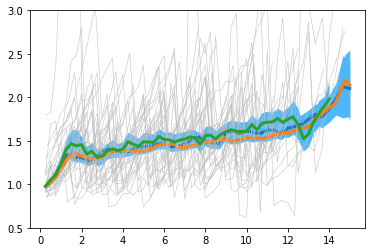

In [20]:
data=pd.read_csv("./CRMdataSizersyn.csv")

for r in [1,2,3]:
    df=data[data.Replica==r]
    for i in range (10):
        mom=df.Mother.unique()[i]
        dfmom=df[df.Mother==mom]
        plt.plot(dfmom.time,dfmom.Size,lw=0.5,c='#bebebe')
    
    tarray=np.sort(df.time.unique())
    #print(tarray)
    meansz4=[]
    errorsz4=[]
    meancv2sz4=[]
    errorcv2sz4=[]
    tarray4=[]
    for t in tarray:
        dft=df[df.time==t]
        #print(dft)
        if (len(dft)>2):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz4.append(mean_cntr[0])
            errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz4.append(errv)
            tarray4.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray4,meansz4,lw=3)
    plt.fill_between(tarray4, np.array(meansz4)+np.array(errorsz4), np.array(meansz4)-np.array(errorsz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1
#plt.xlim(0,6)
plt.ylim(0.5,3)

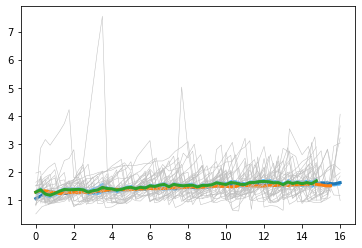

In [21]:
data=pd.read_csv("./CRMdataSizer.csv")
meanarr=[18,18,19.2]
i=0
for r in [1,2,3]:
    df=data[data.Replica==r]
    for i in range (10):
        mom=df.Mother.unique()[i]
        dfmom=df[df.Mother==mom]
        plt.plot(dfmom.time,dfmom.Size,lw=0.5,c='#bebebe')
    tarray=np.sort(df.time.unique())
    meansz4=[]
    errorsz4=[]
    meancv2sz4=[]
    errorcv2sz4=[]
    tarray4=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(dft)>2):
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz4.append(mean_cntr[0])
            errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz4.append(errv)
            tarray4.append(t)
     plt.plot(tarray4,meansz4,lw=3)
    plt.fill_between(tarray4, np.array(meansz4)+np.array(errorsz4), np.array(meansz4)-np.array(errorsz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1


Text(0.5, 0, 'Time')

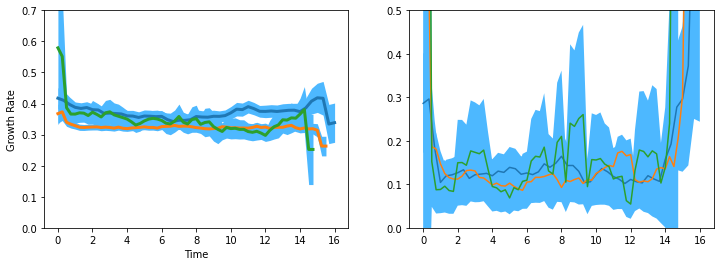

In [22]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,4))
data=pd.read_csv("./CRMdataSizer.csv")
data=data[data.score>0.75]
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    tarray=np.sort(df.time.unique())
    meangr=[]
    errorgr=[]
    meancv2gr=[]
    errorcv2gr=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
            grarr=np.array(dft.gr.tolist())
            grarr=grarr[np.abs(grarr-np.mean(grarr))<3*np.std(grarr)]
            mean_cntr, var_cntr, std_cntr = bayesest(dft.gr,alpha=0.95)
            meangr.append(mean_cntr[0])
            errorgr.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2gr.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2gr.append(errv)
    ax[0].plot(tarray,meangr,lw=3)
    ax[0].fill_between(tarray, np.array(meangr)+np.array(errorgr), np.array(meangr)-np.array(errorgr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    ax[1].plot(tarray,meancv2gr)
    ax[1].fill_between(tarray, np.array(meancv2gr)+np.array(errorcv2gr), np.array(meancv2gr)-np.array(errorcv2gr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    
ax[0].set_ylim([0,0.7])
ax[1].set_ylim(0,0.5)
ax[0].set_ylabel('Growth Rate')
ax[0].set_xlabel('Time')


-0.19492150777248307


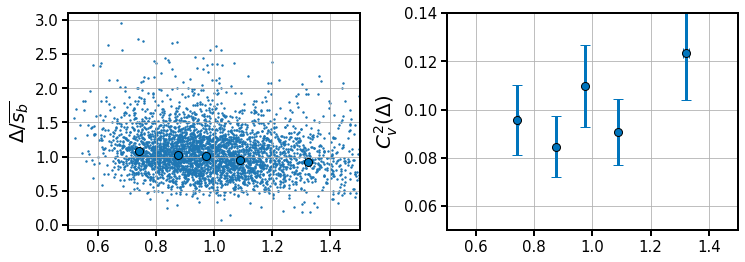

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
data2=pd.read_csv("./DSMdataSizer.csv")
data2=data2[data2.score>0.8]
ax[0].scatter(data2.Sb/np.mean(data2.Sb),(data2.Sd-data2.Sb)/np.mean(data2.Sb),s=2)

quantnumber=5
pvadd2=data2
CV2d=[]
delt=[]
sb=[]
    
errcv2d=[]
errdelt=[]
errsb=[]
for i in range(quantnumber):
    lperv0=np.percentile(pvadd2.Sb,i*100/quantnumber)
    hperv0=np.percentile(pvadd2.Sb,(i+1)*100/quantnumber)
    quanta1=pvadd2[pvadd2.Sb>lperv0]
    quanta2=quanta1[quanta1.Sb<hperv0]     
    mean_cntr, var_cntr, std_cntr = bayesest((quanta2.Sd-quanta2.Sb)/np.mean(pvadd2.Sd-pvadd2.Sb),alpha=0.95)
    meanv0_cntr, varv0_cntr, stdv0_cntr = bayesest(quanta2.Sb/np.mean(pvadd2.Sb),alpha=0.95)
    CV2d.append(var_cntr[0]/mean_cntr[0]**2)
    delt.append(mean_cntr[0])
    sb.append(meanv0_cntr[0])
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2d.append(errv)
    errdelt.append(mean_cntr[1][1]-mean_cntr[0])
    errsb.append(meanv0_cntr[1][1]-meanv0_cntr[0])
ax[0].errorbar(np.array(sb),np.array(delt),xerr=errsb,yerr=errdelt, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].errorbar(np.array(sb),CV2d,xerr=errsb,yerr=errcv2d, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].set_ylim([0,0.3])


ax[0].set_xlim(0.5,1.5)
ax[1].set_xlim(0.5,1.5)
for i in [0,1]:
    ax[i].grid()
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].tick_params(axis='both', width=2,length=6)
        #ax[i].legend(fontsize=15)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel(r'$\Delta/\overline{s_b}$',size=20)
ax[1].set_ylabel(r'$C^2_v(\Delta)$',size=20)
ax[1].set_ylim(0.05,0.14)
print(np.corrcoef(data2.Sb/np.mean(data2.Sb),(data2.Sd-data2.Sb)/np.mean(data2.Sb))[0,1])

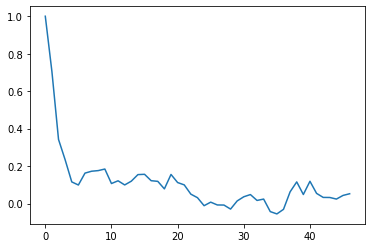

In [24]:
data=pd.read_csv("./CRMdataSizer.csv")
data=data[data.time>3.75]

data=data[data.Replica!=1.0]
tarr=data.time.unique()
timebet=tarr[1]-tarr[0]
tauarr=tarr[:25]
datacorr=[]
mnarr=[]

mnarr=[]
stdarr=[]
for t in tarr:
    dft=data[data.time==t]
    mnarr.append(np.mean(dft.Size))
    stdarr.append(np.std(dft.Size))
for j in range(len(tarr)):
    data1=[]
    data2=[]
    for rep in data.Replica.unique():
        dfrep=data[data.Replica==rep]
        for mom in dfrep.Mother.unique():
            dfmom=dfrep[dfrep.Mother==mom]
            sizes=dfmom.Size.tolist()
            if len(sizes)>j:
                data1.append((sizes[0]-mnarr[0])/stdarr[0])
                data2.append((sizes[j]-mnarr[j])/stdarr[j])
    if len (data1)>1 and len(data2)>1:
        corr,err=bootcorr(data1,data2)
        datacorr.append([j*timebet,corr,err])
singledf=pd.DataFrame(datacorr,columns=['Time','Corr','ErrCorr'])

singledf.to_csv('./CorrelationSizer.csv',index=False)
plt.plot(singledf.Corr)


<ipython-input-26-a50b3294735e>:19: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3


(0.75, 2.0)

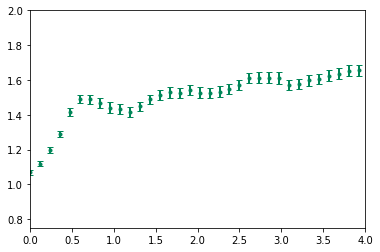

In [26]:
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>2):
        szs=np.array(dft.Size.tolist())
        szs=szs[np.abs(szs-np.mean(szs))<3.*np.mean(szs)]
        mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tarray4)-0.25)/2.1,1.1*np.array(meansz4),yerr=errorsz4,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
    
plt.xlim(0,4)
plt.ylim(0.75,2)

<ipython-input-28-27b28d96535d>:19: RuntimeWarning: invalid value encountered in double_scalars
  errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
C:\Users\cesar_nieto\anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cesar_nieto\anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


(0.0, 0.15)

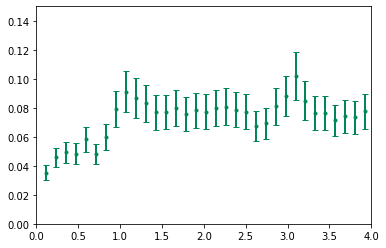

In [28]:
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>2):
        szs=np.array(dft.Size.tolist())
        szs=szs[np.abs(szs-np.mean(szs))<3.*np.mean(szs)]
        mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tarray4))/2.1,meancv2sz4,yerr=errorcv2sz4,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.xlim(0,4)
plt.ylim(0,0.15)